#  Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## **Descrition**
### Two similar datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

### Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

### The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. 

In [225]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns3 
import warnings   # remove all warnings from the output
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth',-1)

In [226]:
df_titanic = pd.read_csv('train.csv')                    

## **1.1 Overview**
* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [227]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [228]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## **1.2 Drop irrelevant features**

In [229]:
# Delete columns of features uncorrelated to prediction
def dropfea(df): 
    df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
    
dropfea(df=df_titanic)

In [230]:
df_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [231]:
#calculate null percentage
def null(df, feature, plot=False):
    t = df[feature].isna().mean() * 100
    print(f'% of null: {t}%')
    if plot:
        sns.countplot(df[feature], palette='Set3')

In [232]:
# Check which cols have null value
x = df_titanic.isnull().sum()
x

Survived    0  
Pclass      0  
Sex         0  
Age         177
SibSp       0  
Parch       0  
Fare        0  
Cabin       687
Embarked    2  
dtype: int64

In [233]:
null(df_titanic,'Age')

% of null: 19.865319865319865%


In [234]:
null(df_titanic,'Cabin')

% of null: 77.10437710437711%


In [235]:
null(df_titanic,'Embarked')

% of null: 0.22446689113355783%


In [236]:
#use sklearn to manually split train and test data, test data is survived col
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_titanic.drop(columns=["Survived"]), df_titanic["Survived"], 
                                                    test_size=0.3, random_state=42)

In [237]:
# handling missing values
def fillnull(df):
    df['Age'].fillna(df['Age'].median, inplace=True)
    df['Cabin'].fillna("Unknown", inplace=True)
    df['Embarked'].fillna(df['Embarked'].unique()[0], inplace=True)

In [239]:
fillnull(X_train)
fillnull(X_test)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 445 to 102
Data columns (total 8 columns):
Pclass      623 non-null int64
Sex         623 non-null object
Age         623 non-null object
SibSp       623 non-null int64
Parch       623 non-null int64
Fare        623 non-null float64
Cabin       623 non-null object
Embarked    623 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 43.8+ KB


In [240]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# encoding categorical features
from sklearn.preprocessing import LabelEncoder
#The only different is that LabelEncoder returned an array, while OrdinalEncoder returned each element inside an array of arrays.
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression


#categorical data preprocessing 
categorical_features = ['Embarked', 'Sex', 'Cabin']
categorical_transformer = ColumnTransformer([
    ('CatOneHot',OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

scaler = ColumnTransformer([
    ('scale',StandardScaler(with_mean=False),slice(0,-1))
])

classifier = LogisticRegression()

In [241]:
from sklearn import set_config
set_config(display='diagram')

In [242]:
fpp = make_pipeline(categorical_transformer,scaler,classifier)
fpp.fit(X_train, y_train)

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(transformers=[('CatOneHot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Sex',
                                                   'Cabin'])])),
                ('columntransformer-2',
                 ColumnTransformer(transformers=[('scale',
                                                  StandardScaler(with_mean=False),
                                                  slice(0, -1, None))])),
                ('logisticregression', LogisticRegression())])

In [246]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = fpp.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred),3)*100
print(f"The accuracy of the model is: {accuracy}%")
print('classifictaion report: ')
print(classification_report(y_test, y_pred))

The accuracy of the model is: 78.0%
classifictaion report: 
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       157
           1       0.75      0.70      0.73       111

    accuracy                           0.78       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268



In [270]:
def plot_confusion_matrix(confusion_mat):
    fig=sns.heatmap(confusion_mat,annot=True, square=True, cmap="Blues", fmt='g')# FMT: The type of data shown in the table
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

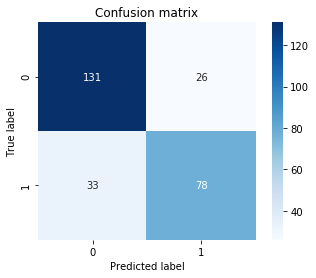

In [271]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mat) 

## **1.2 Logistics Regression**

## accuracy of classifier prediction function

In [245]:
cross_predict = make_pipeline(categorical_transformer,scaler,classifier)

In [306]:
from sklearn.model_selection import cross_val_score

x_df = df_titanic.drop(columns=["Survived"])
y_df = df_titanic["Survived"]

# fill missing data
fillnull(x_df)

# cross_validation evaluation
def print_evaluate(classifier,model,score):
    pred=cross_val_score(model,x_df,y_df,cv=6,scoring=score)
    print('K-fold cross-validation results:')
    print(classifier + ' avarage '+score + ' is: %2.3f'% pred.mean()) 

In [307]:
print_evaluate('Logistic Regression',cross_predict,'accuracy')
print_evaluate('Logistic Regression',cross_predict,'f1_macro')

K-fold cross-validation results:
Logistic Regression avarage accuracy is: 0.778
K-fold cross-validation results:
Logistic Regression avarage f1_macro is: 0.763


In [343]:
from sklearn.metrics import roc_curve, auc

def plot_curve(y_test,y_pred):
    [fpr,tpr,threshold] = roc_curve(y_test,y_pred)# false positive rates ,true positive rates
    idx = np.min(np.where(tpr>0.7))
    plt.figure()
    plt.plot(fpr,tpr,color='coral',label='roc curve (area = %0.3f)'%auc(fpr,tpr))
    plt.plot([0,1],[0,1],'k--')
    plt.plot([0,fpr[idx]],[tpr[idx],tpr[idx]],'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]],[0,tpr[idx]],'k--', color='blue')    
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.01])
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Roc Curve')  
    plt.legend(loc="lower right") 
    plt.draw()


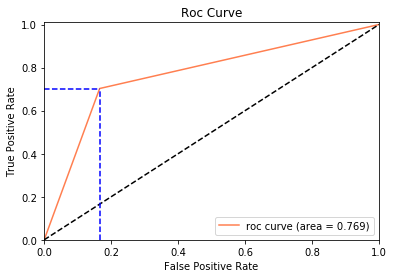

In [344]:
plot_curve(y_test,y_pred)